In [14]:
import pandas as pd
import sys
sys.path.append('../utils')
from image_processing_helper import *
from radiomics_helper import *   
import os
import shutil

import numpy as np
import radiomics
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
import torch
import radiomics
from radiomics import featureextractor
import os
from radiomics.featureextractor import getFeatureClasses, getImageTypes, getParameterValidationFiles
from radiomics import imageoperations

## Consolidating data from different races into single folder

In [15]:
mass_dir = "C:/HII Lab/Breast Cancer/Breast_Cancer_Ultrasound_Project_AIIMS/data/mass_data/"
busi_dir = "C:/HII Lab/Breast Cancer/Breast_Cancer_Ultrasound_Project_AIIMS/data/mass_data/Dataset_BUSI/Dataset_BUSI_with_GT/malignant/"
breast_dir = "C:/HII Lab/Breast Cancer/Breast_Cancer_Ultrasound_Project_AIIMS/data/mass_data/BREAST/"
aiims_dir = "C:/HII Lab/Breast Cancer/Breast_Cancer_Ultrasound_Project_AIIMS/data/mass_data/AIIMS_Delhi_Mass_Data/"

In [16]:
# busi_ls = []
# for fname in os.listdir(busi_dir):
#     if fname.rfind('mask') == -1:
#         busi_hmap = {}
#         busi_hmap['patient_id'] = fname.split('(')[1].split(')')[0]
#         busi_hmap['image_id'] = fname.split('(')[1].split(')')[0]
#         busi_hmap['img_path'] = os.path.join(busi_dir, fname)
#         busi_hmap['mask_path'] = os.path.join(busi_dir, fname.split('.')[0] + '_mask.png' )
#         busi_ls.append(busi_hmap)
# busi_df = pd.DataFrame(busi_ls)
# busi_df['source'] = 'BUSI'

In [17]:
# breast_ls = []
# for fname in os.listdir(breast_dir):
#     if fname.rfind('tumor') != -1:
#         breast_hmap = {}
#         breast_hmap['patient_id'] = int(fname[4:7])
#         breast_hmap['image_id'] = int(fname[4:7])
#         breast_hmap['img_path'] = os.path.join(breast_dir, fname.split('_')[0] + '.png')
#         breast_hmap['mask_path'] = os.path.join(breast_dir, fname )
#         breast_ls.append(breast_hmap)
# breast_df = pd.DataFrame(breast_ls)
# breast_df['source'] = 'BREAST'

# labels = pd.read_excel('C:\HII Lab\Breast Cancer\Breast_Cancer_Ultrasound_Project_AIIMS\data\mass_data\BREAST\clinical_data.xlsx')
# breast_df = breast_df[breast_df['patient_id'].isin(labels[labels['Classification'] == 'malignant']['CaseID'].values)]

In [18]:
# aiims_ls = []
# for fname in os.listdir(aiims_dir + 'images/'):
#     aiims_hmap = {}
#     aiims_hmap['image_id'] = fname.split('.')[0]
#     if fname.split('.')[0].rfind('_') != -1:
#         aiims_hmap['patient_id'] = int(fname.split('.')[0].split('_')[0])
#     else:    
#         aiims_hmap['patient_id'] = int(fname.split('.')[0])
#     aiims_hmap['img_path'] = os.path.join(aiims_dir + 'images/', fname)
#     aiims_hmap['mask_path'] = os.path.join(aiims_dir + 'labels/', fname.split('.')[0] + '.jpg')
#     aiims_ls.append(aiims_hmap)
# aiims_df = pd.DataFrame(aiims_ls)
# aiims_df['source'] = 'AIIMS'

In [19]:
# pd.concat([busi_df, breast_df, aiims_df], ignore_index=True).to_csv(mass_dir + 'multiethnic_malignant_data.csv', index=False)

In [20]:
# # create destination folders if they do not exist
# os.makedirs("images", exist_ok=True)
# os.makedirs("masks", exist_ok=True)

# def build_image_name(row):
#     # e.g. "97_1_BUSI.png" (extension will be added later)
#     return f"{row['image_id']}_{row['source']}"

# def build_mask_name(row):
#     # e.g. "97_1_BUSI_mask.png"
#     return f"{row['image_id']}_{row['source']}_mask"

# img_names = []
# mask_names = []

# for _, row in df.iterrows():
#     img_src = row["img_path"]
#     mask_src = row["mask_path"]

#     # keep original extension
#     img_ext = os.path.splitext(img_src)[1]
#     mask_ext = os.path.splitext(mask_src)[1]

#     img_name = build_image_name(row) + img_ext
#     mask_name = build_mask_name(row) + mask_ext

#     img_dst = os.path.join("images", img_name)
#     mask_dst = os.path.join("masks", mask_name)

#     # copy files
#     shutil.copy2(img_src, img_dst)
#     shutil.copy2(mask_src, mask_dst)

#     img_names.append(img_name)
#     mask_names.append(mask_name)

# # add new columns to dataframe
# df["image_name"] = img_names
# df["mask_name"] = mask_names

In [21]:
# df.to_csv(mass_dir + 'multiethnic_malignant_data_final.csv', index=False)

In [22]:
def resize_all_images(input_dir, output_dir=None, size=(256, 256)):
    """
    Resize all images in input_dir to `size` using OpenCV and save them.

    If output_dir is None, images are overwritten in-place.
    Otherwise, resized images are saved to output_dir
    with the same filenames.
    """
    if output_dir is None:
        output_dir = input_dir
    os.makedirs(output_dir, exist_ok=True)

    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

    for fname in os.listdir(input_dir):
        if not fname.lower().endswith(exts):
            continue

        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)

        img = cv2.imread(in_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Skipping {fname}: could not read image")
            continue

        # size is (width, height)
        resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        cv2.imwrite(out_path, resized)

resize_all_images("../data/mass_data/Harmonized_Data/masks", size=(256, 256))

In [23]:
params = {}

# Normalization (CRITICAL for Ultrasound)
params['normalize'] = True
params['normalizeScale'] = 100  # Rescales image intensities to 0-100 range
params['removeOutliers'] = 3    # Remove statistical outliers (noise)

# Discretization (How we group pixel values)
params['binWidth'] = 5          # With scale 100, this creates ~20 bins (good for texture)

# Dimension settings
params['force2D'] = True        # Treat slice-by-slice (if you have a 3D volume)
params['force2Ddimension'] = 0  # 0=Axial, usually correct for single US snapshots


# **--- ADDED: ENABLE IMAGE FILTERS/DERIVED IMAGES ---**
# These filter classes will automatically generate derived images
# (e.g., Wavelet, LoG) and compute features on them.
params['imageType'] = {
    'Original': {},          # Features on the original image (must be included)
    'Wavelet': {},           # Wavelet decomposition filters (e.g., LHH, HLH, HHH)
    'LoG': {'sigma': [1.0, 2.0, 3.0]}, # Laplacian of Gaussian filters at different scales (sigma)
    'Square': {},            # I = I^2
    'SquareRoot': {},        # I = sqrt(I)
    'Logarithm': {},         # I = log(I)
    'Exponential': {}        # I = exp(I)
}

# Feature classes to enable
params['featureClass'] = {
    'shape2D': None,           # VITAL for 2D US images
    'firstorder': None,        # Intensity stats
    'glcm': None,              # Texture (Co-occurrence)
    'glrlm': None,             # Texture (Run Length)
    'glszm': None,             # Texture (Size Zone)
    'gldm': None,              # Texture (Dependence)
    'ngtdm': None              # Texture (Neighbor Tone)
}

In [24]:
#Modifying radiomics builder function

def build_radiomic_df(df, img_root, mask_root, params=params):
    data = []
    for _, row in df.iterrows():
        # full paths from new setup
        img_file = row["image_name"]
        mask_file = row["mask_name"]

        img_full_path = os.path.join(img_root, img_file)
        mask_full_path = os.path.join(mask_root, mask_file)

        if os.path.exists(img_full_path) and os.path.exists(mask_full_path):
            img = read_as_grayscale(img_full_path)
            msk = read_as_grayscale(mask_full_path)

            img_sitk = sitk.GetImageFromArray(img)
            msk_sitk = sitk.GetImageFromArray(msk)

            features = extract_radiomic_features(img_sitk, msk_sitk, params)
            if features:
                features["image_name"] = img_file
                data.append(features)

    return pd.DataFrame(data)


In [25]:
df = pd.read_csv('../data/mass_data/Harmonized_Data/multiethnic_malignant_data.csv')

In [26]:
rads = build_radiomic_df(df, img_root="../data/mass_data/Harmonized_Data/images", mask_root="../data/mass_data/Harmonized_Data/masks", params=params)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 nee

In [34]:
rads = rads.merge(df[['image_name', 'patient_id', 'source']], on='image_name', how='left')

In [40]:
for i in rads.columns:
    print(i)

original_shape2D_Elongation
original_shape2D_MajorAxisLength
original_shape2D_MaximumDiameter
original_shape2D_MeshSurface
original_shape2D_MinorAxisLength
original_shape2D_Perimeter
original_shape2D_PerimeterSurfaceRatio
original_shape2D_PixelSurface
original_shape2D_Sphericity
original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_Minimum
original_firstorder_Range
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
original_glcm_Autocorrelation
original_glcm_ClusterProminence
original_glcm_ClusterShade
original_glcm_ClusterTendency
original_glcm_Contrast
original

In [41]:
rads[rads['source'] == 'BUSI']['original_glcm_Contrast'].mean()

14.185450322872542

In [42]:
rads[rads['source'] == 'BREAST']['original_glcm_Contrast'].mean()

19.294620220761338

In [43]:
rads[rads['source'] == 'AIIMS']['original_glcm_Contrast'].mean()

6.2501449347219795

In [44]:
rads

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,exponential_glszm_ZonePercentage,exponential_glszm_ZoneVariance,exponential_ngtdm_Busyness,exponential_ngtdm_Coarseness,exponential_ngtdm_Complexity,exponential_ngtdm_Contrast,exponential_ngtdm_Strength,image_name,patient_id,source
0,0.427575,258.261424,248.71268564349506,21773.5,110.426173,714.9015869776665,0.03283356313765203,21774.0,0.731683,-141.78467475217164,...,0.013594194911362175,8397.665220964207,3.790347046655941,0.02200487515007458,0.18381407513778483,1.5977482469743586e-05,1.3376844282511595,1_BUSI.png,1,BUSI
1,0.866748,53.374810,59.54829972383762,1851.5,46.262489,193.88225099390883,0.10471631163592159,1852.0,0.786735,-111.49346470224981,...,0.11663066954643629,155.0500685871056,4.154472404313808,0.00294581732115135,698.5043216922389,0.04695687482830648,35.99944996798321,10_BUSI.png,10,BUSI
2,0.467368,104.132100,109.65856099730654,3751.5,48.668011,316.5929291125642,0.08439102468680906,3752.0,0.685814,-89.79305784804934,...,0.13272921108742003,300.47775035886514,0.7444347614348513,0.016148052506993756,141.13687953042813,0.002864572290006086,79.72389214320353,100_BUSI.png,100,BUSI
3,0.639448,142.882441,168.67127793433,8769.5,91.365847,565.4873734152934,0.06448342247736968,8770.0,0.587042,-149.19353221352358,...,0.07776510832383124,669.0476346092655,1.9002148411274278,0.007042253521126759,107.21530683648595,0.0014353657883919109,52.27783909073868,101_BUSI.png,101,BUSI
4,0.780835,120.795773,142.88806808127822,8005.5,94.321565,491.0609665441002,0.06134044925914686,8006.0,0.645898,-142.88692254486176,...,0.09605296027979016,572.6529886143998,2.258390585003858,0.006025452002977355,171.66330439605028,0.0033029572421921925,24.35409509886985,102_BUSI.png,102,BUSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,0.743131,206.600638,218.55205329623422,24416.5,153.531247,2302.622725301515,0.09430601131618024,24512.0,0.240560,-98.33858074323965,...,0.03508485639686684,3526.9406922660896,1.7204972500175448,0.026312371387443013,1.241725404927673,1.4584488341323847e-05,25.83729931294091,97_1_AIIMS.tif,97,AIIMS
614,0.624874,236.109404,254.65663156493687,26458.0,147.538620,2563.10504808295,0.09687448212574458,26593.0,0.224966,-133.8309235414308,...,0.033317038318354454,4197.411748594896,1.2356387688141244,0.02668717905488469,4.864793269571615,7.543599301177315e-05,70.88357184854002,97_2_AIIMS.tif,97,AIIMS
615,0.905480,132.198542,154.1590088188167,11569.0,119.703096,1985.3435046879083,0.17160891215212276,11670.0,0.192051,-174.28833131868728,...,0.05269922879177378,1428.5831449534012,1.0011797511797513,0.5000535618639529,0.0003427224979421965,1.284429358210917e-07,0.5714285714285714,99_AIIMS.tif,99,AIIMS
616,0.826451,70.863612,79.22752047110903,2885.0,58.565333,840.3300858899145,0.29127559302943307,2925.0,0.226583,-100.30905529226384,...,0.10837606837606838,345.81592015046425,3.454751735184196,0.03766951280763436,0.3305512164659014,0.000419432775333367,0.7642825011246064,9_1_AIIMS.tif,9,AIIMS


# UMAP

In [64]:
def plot_umap(embedding, y, title):
    df_umap = pd.DataFrame({
        "UMAP1": embedding[:, 0],
        "UMAP2": embedding[:, 1],
        "source": y,
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_umap,
        x="UMAP1",
        y="UMAP2",
        hue="source",
        palette="tab10",
        s=40,
        alpha=0.9,
    )
    plt.title(title)
    plt.legend(title="Ethnicity/source", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [ ]:
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_umap_by_ethnicity(rads_df, n_components=2, random_state=40):
    # 1) split into feature matrix X and label vector y
    feature_cols = [c for c in rads_df.columns 
                    if c not in ["source", "image_name", "patient_id"]]
    rads_df[feature_cols] = rads_df[feature_cols].apply(pd.to_numeric, errors="coerce")
    X = rads_df[feature_cols].values
    y_str = rads_df["source"].values           # e.g. ["BUSI", "BUSI", "AIIMS", ...]
    # map each unique source to an integer
    unique_sources, y_int = np.unique(y_str, return_inverse=True)

    # 2) configure UMAP
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=8,      # neighbourhood size; tune in sensitivity analysis
        min_dist=0.05,        # how tightly points pack in the embedding
        metric="euclidean",
        random_state=random_state,
    )

    # unsupervised embedding
    embedding = reducer.fit_transform(X)

    # optional: supervised variant that encourages separation by source
    reducer_sup = umap.UMAP(
        n_components=n_components,
        n_neighbors=15,
        min_dist=0.2,
        metric="euclidean",
        random_state=random_state,
    )
    embedding_sup = reducer_sup.fit_transform(X, y_int)

    return embedding, embedding_sup, y_int

c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


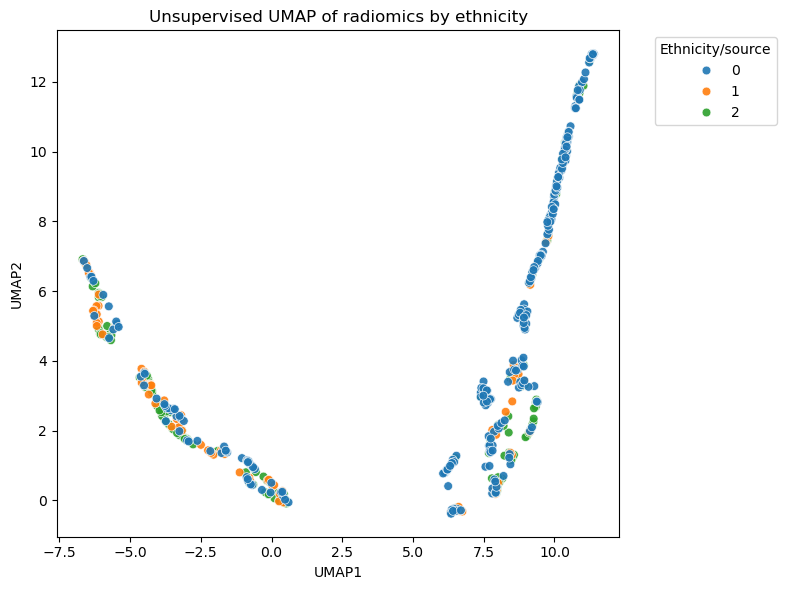

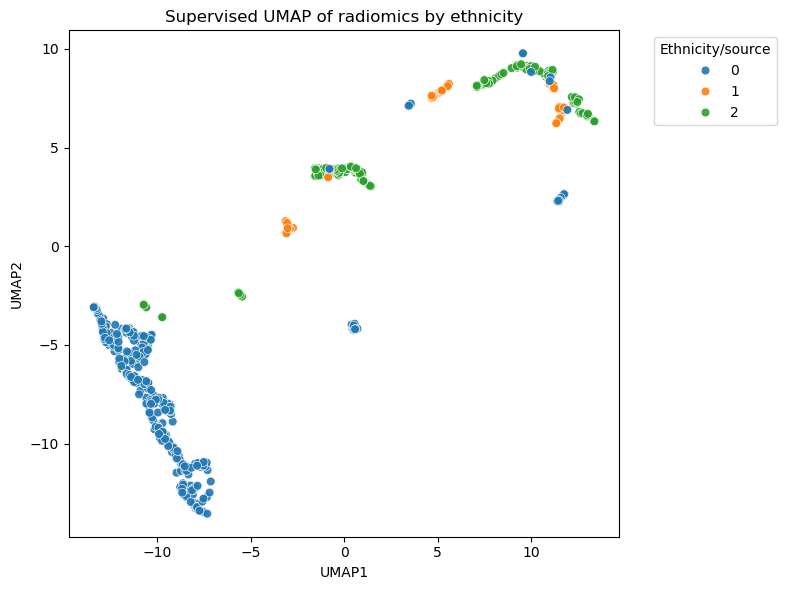

In [99]:
emb_unsup, emb_sup, y = run_umap_by_ethnicity(rads, n_components=4, random_state=42)
plot_umap(emb_unsup, y, "Unsupervised UMAP of radiomics by ethnicity")
plot_umap(emb_sup,  y, "Supervised UMAP of radiomics by ethnicity")

# PCA

In [101]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_pca_by_ethnicity(rads_df, n_components=2, random_state=40):
    # 1) build numeric feature matrix X
    feature_cols = [
        c for c in rads_df.columns
        if c not in ["source", "image_name", "patient_id"]
    ]
    rads_df = rads_df.copy()
    rads_df[feature_cols] = rads_df[feature_cols].apply(
        pd.to_numeric, errors="coerce"
    )
    X = rads_df[feature_cols].values

    # 2) labels: keep both string and integer-encoded versions
    y_str = rads_df["source"].values
    unique_sources, y_int = np.unique(y_str, return_inverse=True)

    # 3) fit PCA
    pca = PCA(n_components=n_components, random_state=random_state)
    pcs = pca.fit_transform(X)        # shape (n_samples, 2) if n_components=2

    # 4) wrap in DataFrame for plotting
    df_pca = pd.DataFrame({
        "PC1": pcs[:, 0],
        "PC2": pcs[:, 1],
        "source_str": y_str,
        "source_int": y_int,
    })

    return df_pca, pca


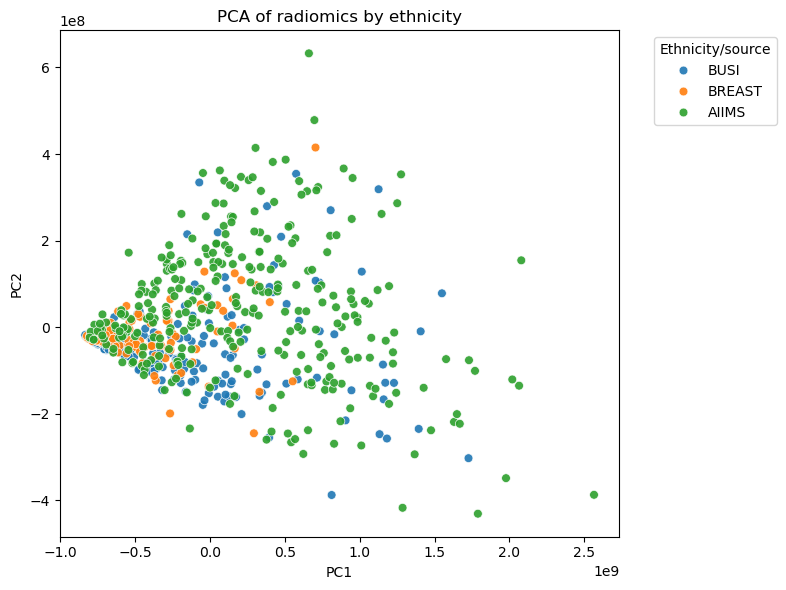

In [103]:
df_pca, pca_model = run_pca_by_ethnicity(rads, n_components=2, random_state=23)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="source_str",
    palette="tab10",
    s=40,
    alpha=0.9,
)
plt.title("PCA of radiomics by ethnicity")
plt.legend(title="Ethnicity/source", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [132]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_matplotlib(df, x_col, y_col, color_col, title=None, xlim=None, ylim=None):
    """
    Plots a scatterplot using ONLY matplotlib with optional axis limits.
    
    Parameters:
    - xlim: Tuple or list (min, max), e.g., (0, 150)
    - ylim: Tuple or list (min, max), e.g., (0, 10)
    """
    # 1. CLEANING: Ensure the color column is strictly strings
    df[color_col] = df[color_col].astype(str)
    
    plt.figure(figsize=(10, 6))
    
    # 2. Loop through groups to plot
    groups = df[color_col].unique()
    
    for group in groups:
        subset = df[df[color_col] == group]
        plt.scatter(
            subset[x_col], 
            subset[y_col], 
            label=group, 
            alpha=0.7, 
            s=100
        )
    
    # 3. Apply Axis Limits if provided
    if xlim is not None:
        plt.xlim(xlim)
        
    if ylim is not None:
        plt.ylim(ylim)
    
    # 4. Labels and Layout
    plt.title(title if title else f'{y_col} vs {x_col} by {color_col}', fontsize=15)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.legend(title=color_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---


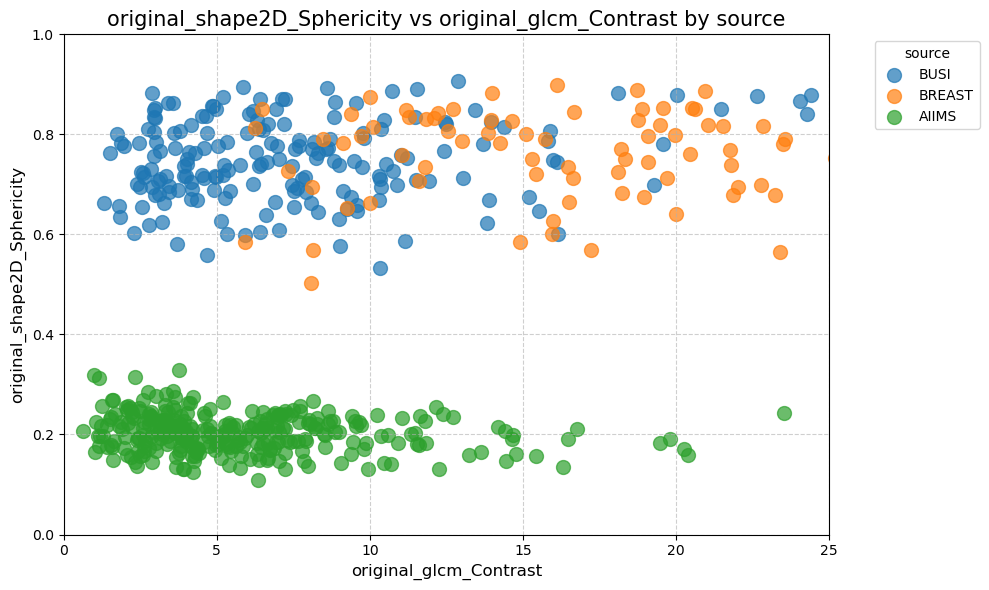

In [146]:
plot_scatter_matplotlib(
    rads, 
    x_col='original_glcm_Contrast', 
    y_col='original_shape2D_Sphericity', 
    color_col='source',
    xlim=(0, 25),  # Limit X axis from 0 to 200
    ylim=(0, 1)    # Limit Y axis from 0 to 20
)

Fitting model (this may take a moment)...
Optimal Regularization (C): 2.782559402207126

Selected 5 features out of 663:
                            Feature  Importance
4       original_shape2D_Sphericity    3.522114
3     original_shape2D_PixelSurface    0.059363
1  original_shape2D_MajorAxisLength    0.051010
0       original_shape2D_Elongation    0.044269
5                        patient_id    0.029579


c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\rautc\miniforge3\envs\aln_env\lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use 

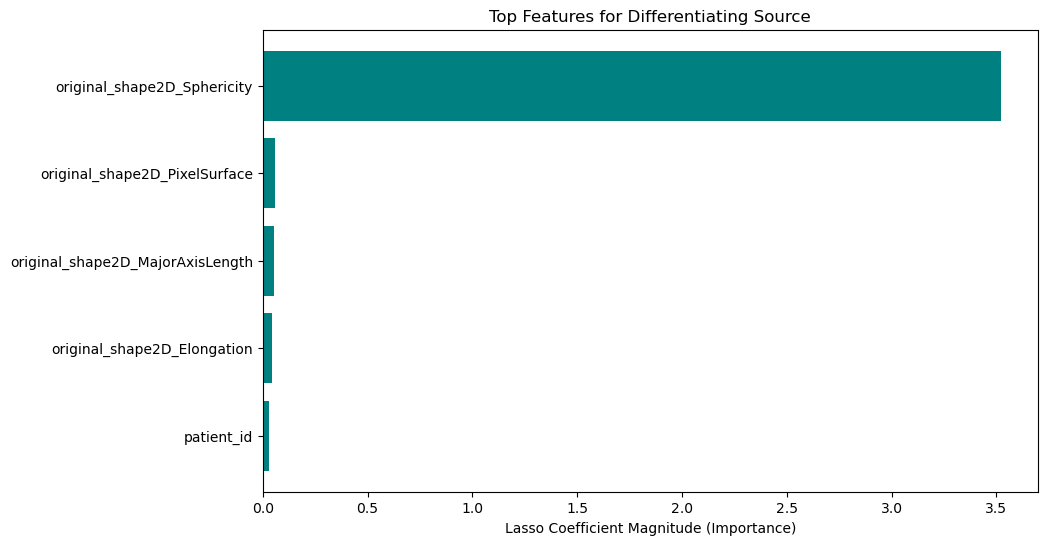

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

def select_features_lasso(df, target_col):
    """
    Uses Logistic Regression with L1 (Lasso) penalty to select features
    that differentiate the target column.
    """
    
    # 1. PREPARATION
    # Drop rows with NaNs to prevent errors
    df_clean = df.dropna()
    
    # Separate Features (X) and Target (y)
    # Select only numeric columns for X, dropping the target if it happens to be numeric
    X = df_clean.select_dtypes(include=[np.number])
    if target_col in X.columns:
        X = X.drop(columns=[target_col])
        
    y = df_clean[target_col]

    # 2. ENCODING & SCALING
    # Lasso is VERY sensitive to scale, so standardization is mandatory
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Encode target labels (e.g., 'BUSI' -> 0)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # 3. MODELING
    # LogisticRegressionCV automatically finds the best 'C' (inverse of alpha)
    # penalty='l1' is the Lasso regularization
    # solver='liblinear' is good for small datasets, 'saga' for large ones
    print("Fitting model (this may take a moment)...")
    model = LogisticRegressionCV(
        cv=5, 
        penalty='l1', 
        solver='liblinear', # Use 'saga' if you have >100k rows or multiclass
        max_iter=5000,      # Increase iterations to ensure convergence
        random_state=42
    )
    
    model.fit(X_scaled, y_encoded)
    
    # 4. EXTRACT IMPORTANCE
    # model.coef_ contains the weights. 
    # If binary classification, shape is (1, n_features). 
    # If multiclass, shape is (n_classes, n_features).
    # We take the absolute mean across classes to see overall importance.
    coefs = np.mean(np.abs(model.coef_), axis=0)
    
    # Create a DataFrame of results
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': coefs
    })
    
    # Filter for selected features (Importance > 0)
    selected_features = feature_importance[feature_importance['Importance'] > 0].sort_values(by='Importance', ascending=False)
    
    return selected_features, model.C_[0]


selected_df, best_c = select_features_lasso(rads, 'source')

print(f"Optimal Regularization (C): {best_c}")
print(f"\nSelected {len(selected_df)} features out of {rads.shape[1]}:")
print(selected_df)

plt.figure(figsize=(10, 6))
top_10 = selected_df.head(10)
plt.barh(top_10['Feature'], top_10['Importance'], color='teal')
plt.xlabel('Lasso Coefficient Magnitude (Importance)')
plt.title('Top Features for Differentiating Source')
plt.gca().invert_yaxis() # Highest importance at top
plt.show()

In [116]:
for i in rads.columns:
    print(i)

original_shape2D_Elongation
original_shape2D_MajorAxisLength
original_shape2D_MaximumDiameter
original_shape2D_MeshSurface
original_shape2D_MinorAxisLength
original_shape2D_Perimeter
original_shape2D_PerimeterSurfaceRatio
original_shape2D_PixelSurface
original_shape2D_Sphericity
original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_Minimum
original_firstorder_Range
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
original_glcm_Autocorrelation
original_glcm_ClusterProminence
original_glcm_ClusterShade
original_glcm_ClusterTendency
original_glcm_Contrast
original